### Import Libraries

In [105]:
import yfinance as yf
import numpy as np
import pandas as pd
import plotly.express as px
import matplotlib.pyplot as plt
import warnings
import math
import time

# Import NeuralProphet
from neuralprophet import NeuralProphet
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler


# Suppress warnings
warnings.filterwarnings('ignore')
emiten = 'DEWA'

### Fungsi untuk Rekayasa Fitur

In [106]:
def create_features(df):
    """Menciptakan fitur-fitur teknikal (sesuai dengan hybrid model)"""
    data = df.copy()

    # Previous Close
    data['Prev Close'] = data['Close'].shift(1)
    
    # Moving Averages
    data['MA20'] = data['Close'].rolling(window=20).mean()
    data['MA50'] = data['Close'].rolling(window=50).mean()

    # RSI
    delta = data['Close'].diff(1)
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)
    gain_avg = gain.rolling(window=14).mean()
    loss_avg = loss.rolling(window=14).mean()
    rs = gain_avg / (loss_avg + 1e-8)
    data['RSI'] = 100 - (100 / (1 + rs))

    # MACD
    data['EMA12'] = data['Close'].ewm(span=12, adjust=False).mean()
    data['EMA26'] = data['Close'].ewm(span=26, adjust=False).mean()
    data['MACD'] = data['EMA12'] - data['EMA26']
    data['Signal Line'] = data['MACD'].ewm(span=9, adjust=False).mean()

    # Bollinger Bands
    data['BB_Upper'] = data['Close'].rolling(window=20).mean() + 2*data['Close'].rolling(window=20).std()
    data['BB_Lower'] = data['Close'].rolling(window=20).mean() - 2*data['Close'].rolling(window=20).std()

    # ATR
    high_low = data['High'] - data['Low']
    high_close = abs(data['High'] - data['Close'].shift(1))
    low_close = abs(data['Low'] - data['Close'].shift(1))
    true_range = pd.concat([high_low, high_close, low_close], axis=1)
    data['ATR'] = true_range.max(axis=1).rolling(window=14).mean()

    # Stochastic
    data['Stochastic_K'] = 100 * (data['Close'] - data['Low'].rolling(window=14).min()) / \
                           (data['High'].rolling(window=14).max() - data['Low'].rolling(window=14).min())
    data['Stochastic_D'] = data['Stochastic_K'].rolling(window=3).mean()

    # CCI
    data['CCI'] = (data['Close'] - data['Close'].rolling(window=20).mean()) / \
                  (0.015 * data['Close'].rolling(window=20).std())

    # OBV
    data['OBV'] = np.where(data['Close'] > data['Close'].shift(1), data['Volume'],
                           np.where(data['Close'] < data['Close'].shift(1), -data['Volume'], 0))
    data['OBV'] = data['OBV'].cumsum()

    # Lag features
    for i in range(1, 6):
        data[f'Lag{i}'] = data['Close'].shift(i)

    data = data.dropna().reset_index()
    return data

### LANGKAH 1: Download Data & Rekayasa Fitur

In [107]:
print("\n📥 Downloading stock data...")
# Kita ambil strukturnya agar aman
data_raw = yf.download(emiten + '.JK',period="5y",interval="1d", progress=False)

# --- FIX STRUKTUR DATA YFINANCE ---
# Jika MultiIndex (ada level Ticker), kita buang level Tickernya
if isinstance(data_raw.columns, pd.MultiIndex):
    data_raw.columns = data_raw.columns.get_level_values(0)

# Pastikan index adalah Datetime
if not isinstance(data_raw.index, pd.DatetimeIndex):
    data_raw.index = pd.to_datetime(data_raw.index)

print("✅ Data downloaded & structure fixed")
print(f"   Shape: {data_raw.shape}")
print(f"   Columns: {data_raw.columns.tolist()}")


📥 Downloading stock data...
✅ Data downloaded & structure fixed
   Shape: (1208, 5)
   Columns: ['Close', 'High', 'Low', 'Open', 'Volume']


### LANGKAH 2: Persiapan Data & Split

In [108]:
print("\n🔧 Creating technical indicators...")
data_featured = create_features(data_raw)

# Setup Dataframe NeuralProphet - gunakan Close sebagai target (sama seperti Prophet)
df_prophet = data_featured.rename(columns={'Date': 'ds', 'Close': 'y'})

# Fitur yang dipilih - sama dengan hybrid model
selected_features = [
    'Prev Close', 'MA20', 'MA50', 'MACD', 'Signal Line',
    'Lag1', 'Lag2', 'Lag3', 'Lag4', 'Lag5', 'RSI',
    'BB_Upper', 'BB_Lower', 'ATR', 'Stochastic_K', 'Stochastic_D', 'CCI', 'OBV', 'Volume'
]

# Siapkan kolom final
columns_for_model = ['ds', 'y'] + selected_features
df_model_ready = df_prophet[columns_for_model]

print("\n📊 Splitting data...")
# Split data secara kronologis
train_size = int(len(df_model_ready) * 0.8)

# Gunakan .copy() untuk memutus referensi pandas (mencegah warning)
train_df = df_model_ready.iloc[:train_size].copy()
test_df = df_model_ready.iloc[train_size:].copy()

print(f"✅ Data split completed")
print(f"   Training samples: {len(train_df)}")
print(f"   Testing samples: {len(test_df)}")
print(f"   Total features: {len(selected_features)}")
print(f"   Target: Close (same as Prophet model)")


🔧 Creating technical indicators...

📊 Splitting data...
✅ Data split completed
   Training samples: 686
   Testing samples: 172
   Total features: 19
   Target: Close (same as Prophet model)


In [109]:
print("\n⚖️  Normalizing technical features (same as Prophet)...")

# Gunakan .copy() untuk menghindari warning
train_df_scaled = train_df.copy()
test_df_scaled = test_df.copy()

scaler = MinMaxScaler()

# Hanya normalisasi kolom FITUR (regressors), JANGAN normalisasi 'y' (Target)
# Fit pada training, transform pada training & testing (SAMA SEPERTI PROPHET)
train_df_scaled[selected_features] = scaler.fit_transform(train_df[selected_features])
test_df_scaled[selected_features] = scaler.transform(test_df[selected_features])

# Update train_df dan test_df dengan versi yang sudah di-scale
train_df = train_df_scaled
test_df = test_df_scaled

print("✅ Features scaled to 0-1 range (same as Prophet)")
print("   Target 'y' (Close) kept in original scale")



⚖️  Normalizing technical features (same as Prophet)...
✅ Features scaled to 0-1 range (same as Prophet)
   Target 'y' (Close) kept in original scale


### LANGKAH 3: Training Model

In [110]:
print("\n🔍 Seed sweep disabled — using fixed seed=42.")
DO_SEED_SWEEP = False
BEST_SEED = 42


🔍 Seed sweep disabled — using fixed seed=42.


In [111]:
print("\n🎯 Seeding for reproducibility (fixed to 42)...")
import os, random
import numpy as np

BEST_SEED = 42  # fixed seed

def set_seed(seed: int) -> int:
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    try:
        import torch
        torch.manual_seed(seed)
        if hasattr(torch, "cuda") and torch.cuda.is_available():
            torch.cuda.manual_seed_all(seed)
        if hasattr(torch.backends, "cudnn"):
            torch.backends.cudnn.deterministic = True
            torch.backends.cudnn.benchmark = False
    except Exception:
        pass
    return seed

set_seed(BEST_SEED)
print(f"✅ Seed set: {BEST_SEED}")


🎯 Seeding for reproducibility (fixed to 42)...
✅ Seed set: 42


In [112]:
print("\n🚂 Training NeuralProphet model (config matched with Prophet)...")

start_time = time.time()

# Ensure seed is applied
try:
    BEST_SEED
except NameError:
    BEST_SEED = 42
set_seed(BEST_SEED)

# Build model - CONFIG DISESUAIKAN DENGAN PROPHET untuk apple-to-apple comparison
try:
    model = NeuralProphet(
        n_forecasts=1,
        n_changepoints=25,        # SAMA dengan Prophet
        learning_rate=0.01,       
        epochs=100,
        batch_size=32,
        loss_func="Huber",
        normalize="minmax",       # NeuralProphet normalize target juga (berbeda dengan Prophet approach)
        daily_seasonality=False,
        weekly_seasonality=True,
        yearly_seasonality=True,
        random_seed=42,
        drop_missing=True,
    )
except TypeError:
    model = NeuralProphet(
        n_forecasts=1,
        n_changepoints=25,
        learning_rate=0.01,
        epochs=100,
        batch_size=32,
        loss_func="Huber",
        normalize="minmax",
        daily_seasonality=False,
        weekly_seasonality=True,
        yearly_seasonality=True,
        drop_missing=True,
    )

# Tambahkan semua fitur sebagai future regressors (loop per fitur)
for feat in selected_features:
    model = model.add_future_regressor(feat)

metrics = model.fit(train_df, freq="D", progress="bar")
training_time = time.time() - start_time

print(f"✅ Training selesai dalam {training_time:.2f} detik | Seed={BEST_SEED}")
print(f"   Config: Closest match to Prophet")
print(f"   - n_changepoints=25 (same as Prophet)")
print(f"   - normalize='minmax' (NeuralProphet handles target internally)")
print(f"   - Features manually scaled with MinMaxScaler (same as Prophet)")
print(f"   - seasonality: weekly+yearly (same as Prophet)")
print(metrics.tail())


WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency B corresponds to 95.773% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.



🚂 Training NeuralProphet model (config matched with Prophet)...
Training: |          | 0/? [00:06<?, ?it/s, v_num=22, train_loss=0.0012, reg_loss=0.000, MAE=1.950, RMSE=2.710, Loss=0.0012, RegLoss=0.000]  
✅ Training selesai dalam 7.05 detik | Seed=42
   Config: Closest match to Prophet
   - n_changepoints=25 (same as Prophet)
   - normalize='minmax' (NeuralProphet handles target internally)
   - Features manually scaled with MinMaxScaler (same as Prophet)
   - seasonality: weekly+yearly (same as Prophet)
    train_loss  reg_loss       MAE      RMSE      Loss  RegLoss  epoch
95    0.001197       0.0  1.953901  2.680334  0.001186      0.0     95
96    0.001198       0.0  1.957777  2.690587  0.001194      0.0     96
97    0.001198       0.0  1.949989  2.733412  0.001217      0.0     97
98    0.001194       0.0  1.949453  2.688201  0.001186      0.0     98
99    0.001197       0.0  1.954513  2.707981  0.001203      0.0     99


### LANGKAH 4: Prediksi

In [113]:
print("\n🔮 Making predictions...")

# Prediksi pada test data
forecast_test = model.predict(test_df)

# Ambil prediksi Close price langsung dari yhat1 (sama seperti Prophet)
reconstructed_prices = forecast_test['yhat1'].values

# Harga aktual dari data asli
original_train_size = len(train_df) + (len(data_featured) - len(df_model_ready))
y_test_actual = data_featured['Close'].iloc[original_train_size:].values

# Pastikan ukuran sama
min_len = min(len(reconstructed_prices), len(y_test_actual))
reconstructed_prices = reconstructed_prices[:min_len]
y_test_actual = y_test_actual[:min_len]

# Hapus NaN values (jika ada)
valid_mask = ~np.isnan(reconstructed_prices) & ~np.isnan(y_test_actual)
reconstructed_prices = reconstructed_prices[valid_mask]
y_test_actual = y_test_actual[valid_mask]

# Simpan hasil raw untuk perbandingan
reconstructed_prices_raw = reconstructed_prices.copy()

print(f"✅ Predictions completed")
print(f"   Predicting Close prices directly (same as Prophet)")
print(f"   Valid test samples: {len(reconstructed_prices)}")
print(f"   Actual samples: {len(y_test_actual)}")

INFO - (NP.df_utils._infer_frequency) - Major frequency B corresponds to 94.186% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency B corresponds to 94.186% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D



🔮 Making predictions...
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 374.12it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column



✅ Predictions completed
   Predicting Close prices directly (same as Prophet)
   Valid test samples: 172
   Actual samples: 172


In [114]:
# Debug: cek prediksi
print("\n🔍 Debug predictions...")
print(f"forecast_test shape: {forecast_test.shape}")
print(f"forecast_test columns: {forecast_test.columns.tolist()}")
print(f"\nFirst 5 yhat1 values:")
print(forecast_test['yhat1'].head())
print(f"\nNumber of NaN in yhat1: {forecast_test['yhat1'].isna().sum()}")
print(f"Total predictions: {len(forecast_test['yhat1'])}")


🔍 Debug predictions...
forecast_test shape: (172, 26)
forecast_test columns: ['ds', 'y', 'yhat1', 'trend', 'season_yearly', 'season_weekly', 'future_regressors_additive', 'future_regressor_ATR', 'future_regressor_BB_Lower', 'future_regressor_BB_Upper', 'future_regressor_CCI', 'future_regressor_Lag1', 'future_regressor_Lag2', 'future_regressor_Lag3', 'future_regressor_Lag4', 'future_regressor_Lag5', 'future_regressor_MA20', 'future_regressor_MA50', 'future_regressor_MACD', 'future_regressor_OBV', 'future_regressor_Prev Close', 'future_regressor_RSI', 'future_regressor_Signal Line', 'future_regressor_Stochastic_D', 'future_regressor_Stochastic_K', 'future_regressor_Volume']

First 5 yhat1 values:
0    116.247688
1    117.750946
2    117.484886
3    119.591095
4    120.288002
Name: yhat1, dtype: float32

Number of NaN in yhat1: 0
Total predictions: 172


In [115]:
print("\n📊 Evaluating RAW prediction (before post-processing)...")

# Evaluasi hasil raw
mae_raw = mean_absolute_error(y_test_actual, reconstructed_prices_raw)
mse_raw = mean_squared_error(y_test_actual, reconstructed_prices_raw)
rmse_raw = math.sqrt(mse_raw)
r2_raw = r2_score(y_test_actual, reconstructed_prices_raw)
mape_raw = np.mean(np.abs((y_test_actual - reconstructed_prices_raw) / y_test_actual)) * 100

# Directional Accuracy (DA) untuk raw
T_raw = len(y_test_actual) - 1
actual_diff_raw = np.diff(y_test_actual)
pred_diff_raw = np.diff(reconstructed_prices_raw)
ai_raw = (np.sign(actual_diff_raw) == np.sign(pred_diff_raw)).astype(int)
da_raw = (1/T_raw) * np.sum(ai_raw) * 100

# Assign ke variabel global untuk export
rmse = rmse_raw
mae = mae_raw
mape = mape_raw
r2 = r2_raw
da = da_raw

print("\n" + "="*70)
print("📊 RAW NEURALPROPHET PREDICTION (No Post-Processing)")
print("="*70)
print(f"RMSE  : {rmse:.4f}")
print(f"MAE   : {mae:.4f}")
print(f"R²    : {r2:.4f}")
print(f"MAPE  : {mape:.2f}%")
print(f"DA    : {da:.2f}%")
print("="*70)


📊 Evaluating RAW prediction (before post-processing)...

📊 RAW NEURALPROPHET PREDICTION (No Post-Processing)
RMSE  : 27.8072
MAE   : 18.0086
R²    : 0.9570
MAPE  : 5.57%
DA    : 54.39%


### LANGKAH 6: Visualisasi


📊 Creating visualizations...
✅ Visualization saved as 'neuralprophet_results.png'


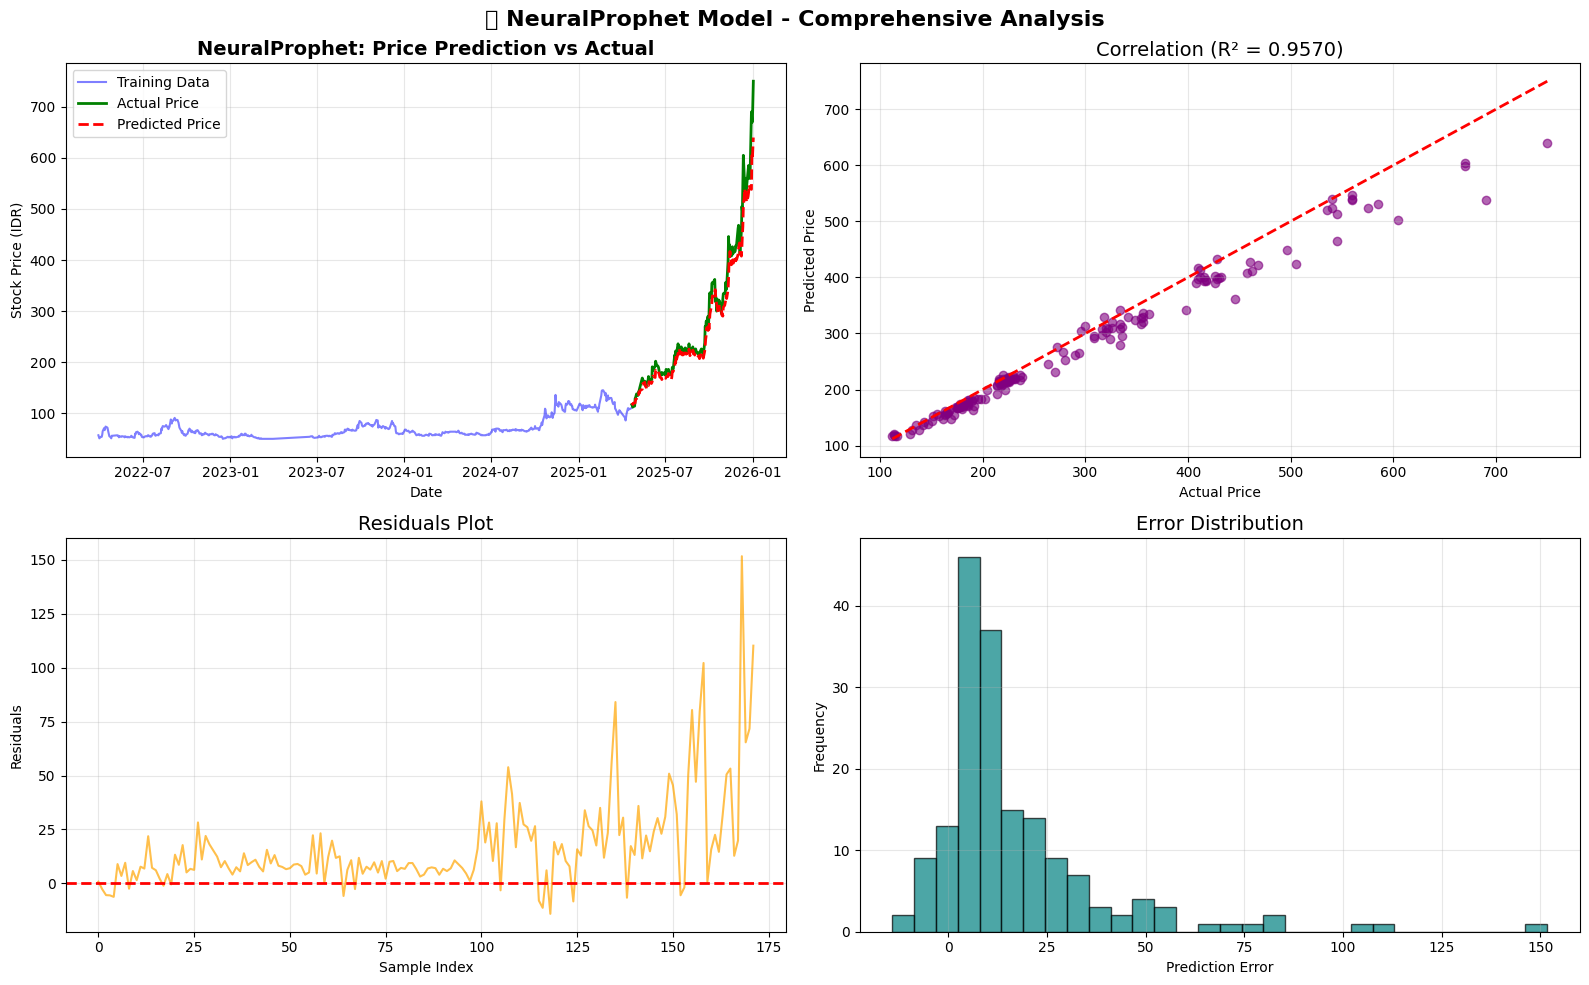


🎉 NeuralProphet Model Analysis Completed!


In [116]:
print("\n📊 Creating visualizations...")
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# Plot 1: Time Series
ax1 = axes[0, 0]
train_dates = data_featured['Date'].iloc[:original_train_size]
train_prices = data_featured['Close'].iloc[:original_train_size]
test_dates = data_featured['Date'].iloc[original_train_size:]

ax1.plot(train_dates, train_prices, label='Training Data', color='blue', alpha=0.5)
ax1.plot(test_dates, y_test_actual, label='Actual Price', color='green', linewidth=2)
ax1.plot(test_dates, reconstructed_prices, label='Predicted Price',
         color='red', linestyle='--', linewidth=2)
ax1.set_title("NeuralProphet: Price Prediction vs Actual", fontsize=14, fontweight='bold')
ax1.set_xlabel("Date")
ax1.set_ylabel("Stock Price (IDR)")
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot 2: Scatter
ax2 = axes[0, 1]
ax2.scatter(y_test_actual, reconstructed_prices, alpha=0.6, color='purple')
ax2.plot([y_test_actual.min(), y_test_actual.max()],
         [y_test_actual.min(), y_test_actual.max()], 'r--', lw=2)
ax2.set_xlabel('Actual Price')
ax2.set_ylabel('Predicted Price')
ax2.set_title(f'Correlation (R² = {r2_raw:.4f})', fontsize=14)
ax2.grid(True, alpha=0.3)

# Plot 3: Residuals
ax3 = axes[1, 0]
residuals = y_test_actual - reconstructed_prices
ax3.plot(residuals, color='orange', alpha=0.7)
ax3.axhline(y=0, color='red', linestyle='--', linewidth=2)
ax3.set_title('Residuals Plot', fontsize=14)
ax3.set_xlabel('Sample Index')
ax3.set_ylabel('Residuals')
ax3.grid(True, alpha=0.3)

# Plot 4: Error Distribution
ax4 = axes[1, 1]
ax4.hist(residuals, bins=30, alpha=0.7, color='teal', edgecolor='black')
ax4.set_title('Error Distribution', fontsize=14)
ax4.set_xlabel('Prediction Error')
ax4.set_ylabel('Frequency')
ax4.grid(True, alpha=0.3)

plt.suptitle('📈 NeuralProphet Model - Comprehensive Analysis', fontsize=16, fontweight='bold')
plt.tight_layout()
# plt.savefig('neuralprophet_results.png', dpi=300, bbox_inches='tight')
print("✅ Visualization saved as 'neuralprophet_results.png'")
plt.show()

print("\n🎉 NeuralProphet Model Analysis Completed!")
print("="*70)

In [117]:
# Export NeuralProphet artifact to repository 'models' with scaler + features
from pathlib import Path
import joblib
import pandas as pd
import numpy as np
from neuralprophet import NeuralProphet

# Prefer the trained variables from above
neural_model = globals().get('model', None)
scaler_obj = globals().get('scaler', None)
feature_cols = globals().get('selected_features', None)

if scaler_obj is None:
    raise RuntimeError('No fitted MinMaxScaler found (variable `scaler`). Run training cells first.')
if neural_model is None or not isinstance(neural_model, NeuralProphet):
    raise RuntimeError('No NeuralProphet model instance found (variable `model`). Run training cells first.')
if feature_cols is None or len(feature_cols) == 0:
    # Fallback: infer from a df that contains ds/y and indicators
    candidate_dfs = [v for v in globals().values() if isinstance(v, pd.DataFrame)]
    known = {
        'Prev Close','MA20','MA50','MACD','Signal Line','Lag1','Lag2','Lag3','Lag4','Lag5','RSI',
        'BB_Upper','BB_Lower','ATR','Stochastic_K','Stochastic_D','CCI','OBV','High','Low','Volume'
    }
    for d in candidate_dfs:
        cols = list(d.columns)
        if 'ds' in cols and ('y' in cols or 'Close' in cols):
            feats = [c for c in cols if c not in ['ds','y','Close']]
            if len(set(feats) & known) >= 5:
                feature_cols = feats
                break
if feature_cols is None or len(feature_cols) == 0:
    raise RuntimeError('Could not determine feature_columns; ensure `selected_features` is defined.')

# Helper: find repo root
def find_repo_root(start: Path) -> Path:
    for p in [start] + list(start.parents):
        if (p / 'requirements.txt').exists() or (p / 'app.py').exists() or (p / '.git').exists():
            return p
    return start

repo_root = find_repo_root(Path.cwd())
export_dir = (repo_root / 'models')
export_dir.mkdir(parents=True, exist_ok=True)

# Collect metrics from earlier cells if available
metrics_map = {
    'rmse': float(globals().get('rmse')) if 'rmse' in globals() and globals().get('rmse') is not None else None,
    'mae': float(globals().get('mae')) if 'mae' in globals() and globals().get('mae') is not None else None,
    'mape': float(globals().get('mape')) if 'mape' in globals() and globals().get('mape') is not None else None,
    'r2': float(globals().get('r2')) if 'r2' in globals() and globals().get('r2') is not None else None,
    'directional_accuracy': float(globals().get('da')) if 'da' in globals() and globals().get('da') is not None else None,
}

artifact = {
    'model_type': 'neuralprophet',
    'neuralprophet': neural_model,
    'scaler': scaler_obj,
    'feature_columns': feature_cols,
    'metrics': metrics_map,
}

artifact_path = export_dir / (emiten + '_neuralprophet_meta.joblib')

# Try joblib dump first; if it fails (pickling issues), fall back to NeuralProphet.save()
try:
    joblib.dump(artifact, str(artifact_path))
    print('✅ Saved artifact:', artifact_path.resolve())
except Exception as e:
    print('⚠️ joblib dump failed; saving via NeuralProphet.save()', e)
    model_dir = export_dir / (emiten + '_neuralprophet_meta.joblib')
    try:
        neural_model.save(str(model_dir))
        meta = {
            'model_type': 'neuralprophet',
            'model_dir': str(model_dir),
            'scaler': scaler_obj,
            'feature_columns': feature_cols,
            'metrics': metrics_map,
        }
        meta_path = export_dir / (emiten + '_neuralprophet_meta.joblib')
        joblib.dump(meta, str(meta_path))
        print('✅ Saved model at:', model_dir.resolve())
        print('✅ Saved meta artifact:', meta_path.resolve())
    except Exception as e2:
        raise RuntimeError(f'Failed to save NeuralProphet model: {e2}')

✅ Saved artifact: C:\Users\PC\JD\__code\python\skripsi\models\DEWA_neuralprophet_meta.joblib
